In [1]:
import dlib
import numpy as np
from PIL import Image
from scipy.spatial import Delaunay
from skimage import transform as tf
from skimage.draw import polygon
import matplotlib.pyplot as plt

from urllib.request import urlretrieve
import bz2
from zipfile import ZipFile
from io import BytesIO

In [2]:
url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
filepath  = urlretrieve(url)[0]
data = bz2.BZ2File(filepath).read()
with open(filepath, 'wb') as f:
    f.write(data)

predictor = dlib.shape_predictor(filepath)
detector = dlib.get_frontal_face_detector()

In [3]:
url_list = [
    'https://fei.edu.br/~cet/frontalimages_manuallyaligned_part1.zip',
    'https://fei.edu.br/~cet/frontalimages_manuallyaligned_part2.zip',
]

archive = [ZipFile(urlretrieve(url)[0], 'r') for url in url_list]
images = [image for zipfile in archive for image in zipfile.namelist()]

In [4]:
neutral = {'filename': [], 'array': [], 'landmarks':[]}
smiling = {'filename': [], 'array': [], 'landmarks':[]}

for image in images:
    try:
        face = Image.open(BytesIO(archive[0].read(image)))
    except:
        face = Image.open(BytesIO(archive[1].read(image)))
    
    face_array = np.array(face)
    rect = detector(face_array)[0]
    sp = predictor(face_array, rect)
    landmarks = np.array([[p.x, p.y] for p in sp.parts()])
    
    if 'a' in image:
        neutral['filename'].append(image)
        neutral['array'].append(face_array)
        neutral['landmarks'].append(landmarks)
        
    if 'b' in image:
        smiling['filename'].append(image)
        smiling['array'].append(face_array)
        smiling['landmarks'].append(landmarks)

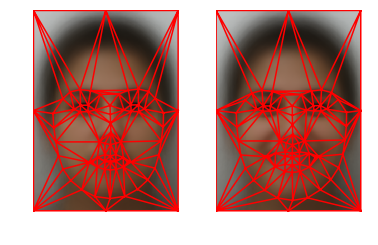

In [5]:
aux = [260,360] * np.array([(0,0),(0,.5),(0,1),(.5,0),(.5,1),(1,0),(1,.5),(1,1)])

for i, dataset in enumerate([neutral, smiling]):
    mean_landmarks = np.mean(dataset['landmarks'], axis=0)
    dataset['template'] = np.append(mean_landmarks, aux, axis=0)
    dataset['simplices'] = Delaunay(dataset['template']).simplices
    
    plt.subplot(1, 2, i+1)
    plt.imshow(np.mean(dataset['array'], axis=0).astype(np.uint8))
    plt.triplot(dataset['template'][:,0], dataset['template'][:,1], dataset['simplices'], color='red')
    plt.axis('off')

In [6]:
for dataset in [neutral, smiling]:
    dataset['warped'] = []
    
    for array, landmarks in zip(dataset['array'], dataset['landmarks']):
        landmarks = np.append(landmarks, aux, axis=0)
        vertices = landmarks[dataset['simplices']]
        template_vertices = dataset['template'][dataset['simplices']]
        
        warped_img = np.zeros((array.shape[0], array.shape[1], 3))
        for vertices_src, vertices_dst in zip(vertices, template_vertices):
            X, Y = polygon(vertices_dst[:,0], vertices_dst[:,1])
            
            vertices_src = np.hstack([vertices_src, np.ones((3, 1))])
            vertices_dst = np.hstack([vertices_dst, np.ones((3, 1))])
            A, _, _, _ = np.linalg.lstsq(vertices_dst, vertices_src, rcond=None)
            
            warped_img[Y, X] = tf.warp(array, tf.AffineTransform(A.T))[Y, X]
            
        dataset['warped'].append(warped_img)

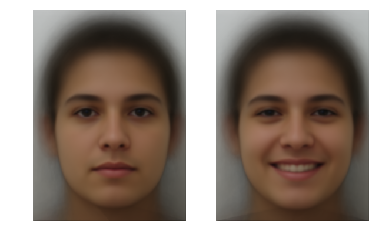

In [7]:
for i, dataset in enumerate([neutral, smiling]):
    plt.subplot(1, 2, i+1)
    plt.imshow((255 * np.mean(dataset['warped'], axis=0)).astype(np.uint8))
    plt.axis('off')